In [5]:
import pandas as pd
import plotnine as pn
memory_bench = pd.read_csv("output/k562_memory_bench/k562_memory_results.csv")

memory_bench

,n_archetypes,n_cells,seed,ok,error,rss_poll_ms,time,time_total,time_copy,time_compute,mem_rss_start_mb,mem_rss_post_copy_mb,mem_rss_end_mb,mem_rss_delta_post_copy_mb,mem_rss_delta_since_start_mb,mem_rss_peak_mb,mem_rss_peak_over_post_copy_mb,mem_rss_peak_over_start_mb,mem_rss_peak_copy_sampled_mb,mem_rss_peak_compute_sampled_mb
0,2,1000,383329927,True,NaN,50,3.230227,3.294101,0.063056,3.230227,37198.089844,37197.062500,37198.019531,0.957031,-0.070312,37198.914062,0.000000,0.824219,37198.281250,37197.964844
1,2,1000,3324115916,True,NaN,50,2.135047,2.186662,0.050789,2.135047,37198.093750,37197.070312,37197.843750,0.773438,-0.250000,37198.921875,0.000000,0.765625,37198.285156,37197.769531
2,2,2000,383329927,True,NaN,50,2.319119,2.450878,0.131005,2.319119,37198.109375,37198.933594,37198.066406,-0.867188,-0.042969,37198.933594,0.000000,0.824219,37198.300781,37198.015625
3,2,2000,3324115916,True,NaN,50,2.224602,2.340973,0.115675,2.224602,37198.109375,37198.933594,37198.074219,-0.859375,-0.035156,37198.933594,0.000000,0.824219,37198.300781,37197.984375
4,2,10000,383329927,True,NaN,50,3.259851,3.478482,0.217978,3.259851,37198.121094,37440.000000,37440.839844,0.839844,242.718750,37680.417969,0.000000,482.296875,37632.292969,37440.332031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,6,100000,3324115916,True,NaN,50,25.475519,27.023770,1.547587,25.475519,37198.195312,39612.730469,39632.589844,19.859375,2434.394531,42025.492188,0.000000,4827.296875,41953.882812,39632.589844
66,6,200000,383329927,True,NaN,50,58.799654,61.585924,2.785447,58.799654,37198.199219,42024.070312,42067.230469,43.160156,4869.031250,46852.000000,0.000000,9653.800781,46833.589844,42067.210938
67,6,200000,3324115916,True,NaN,50,55.435582,58.380445,2.944016,55.435582,37198.199219,42024.070312,42067.238281,43.167969,4869.039062,46852.000000,0.000000,9653.800781,46777.589844,42067.222656
68,6,1000000,383329927,True,NaN,50,349.709151,356.603044,6.893103,349.709151,37198.199219,73382.101562,73442.648438,60.546875,36244.449219,73610.496094,228.394531,36412.296875,73381.847656,73518.933594


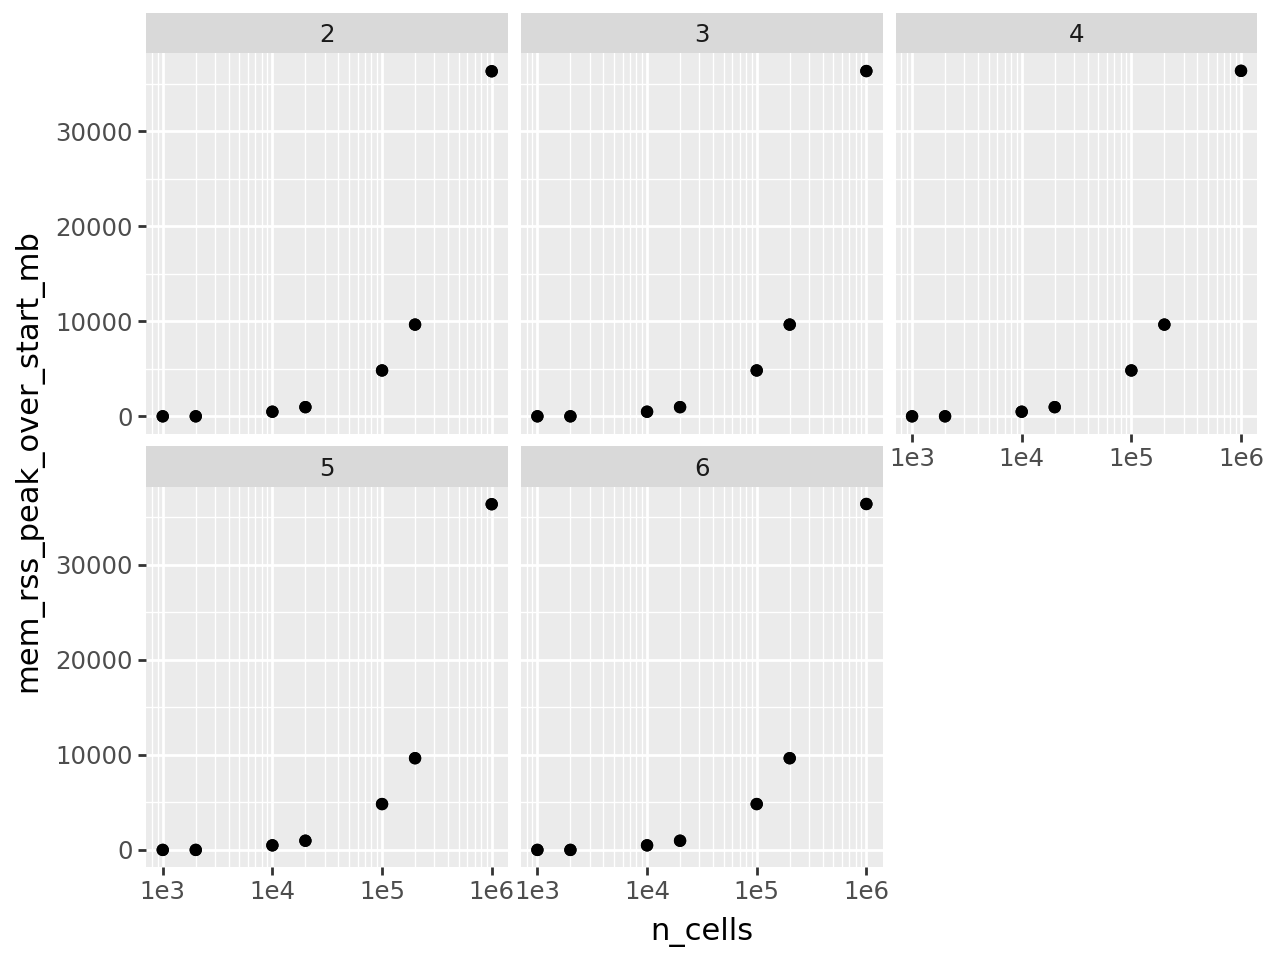

In [ ]:
#pn.ggplot(memory_bench) + pn.geom_point(pn.aes(x="n_cells", y="mem_rss_peak_over_post_copy_mb")) + pn.facet_wrap("n_archetypes") + pn.scale_x_log10()
pn.ggplot(memory_bench) + pn.geom_point(pn.aes(x="n_cells", y="mem_rss_peak_over_start_mb")) + pn.facet_wrap("n_archetypes") + pn.scale_x_log10()

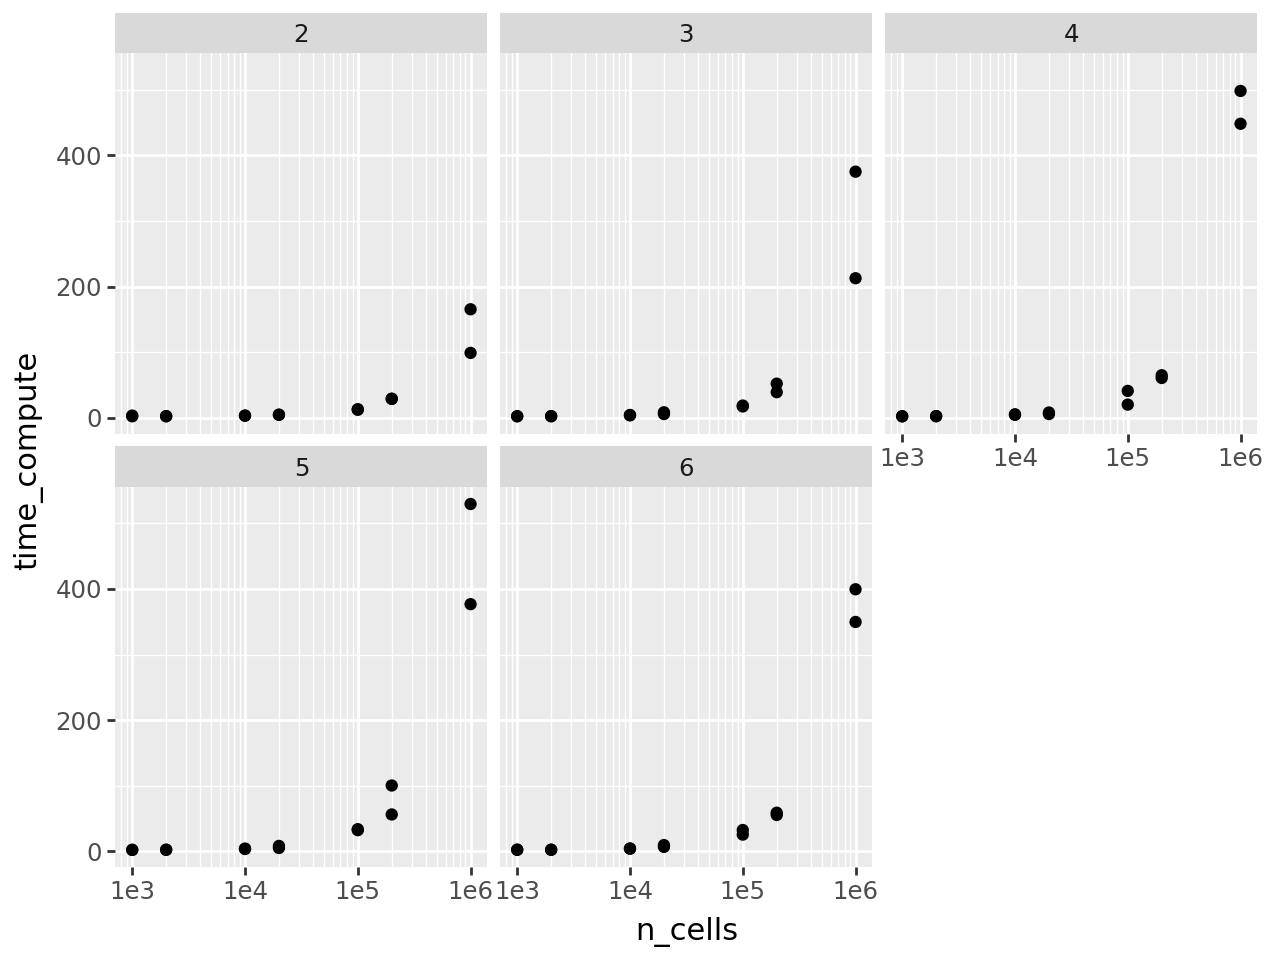

In [16]:
pn.ggplot(memory_bench) + pn.geom_point(pn.aes(x="n_cells", y="time_compute")) + pn.facet_wrap("n_archetypes") + pn.scale_x_log10()

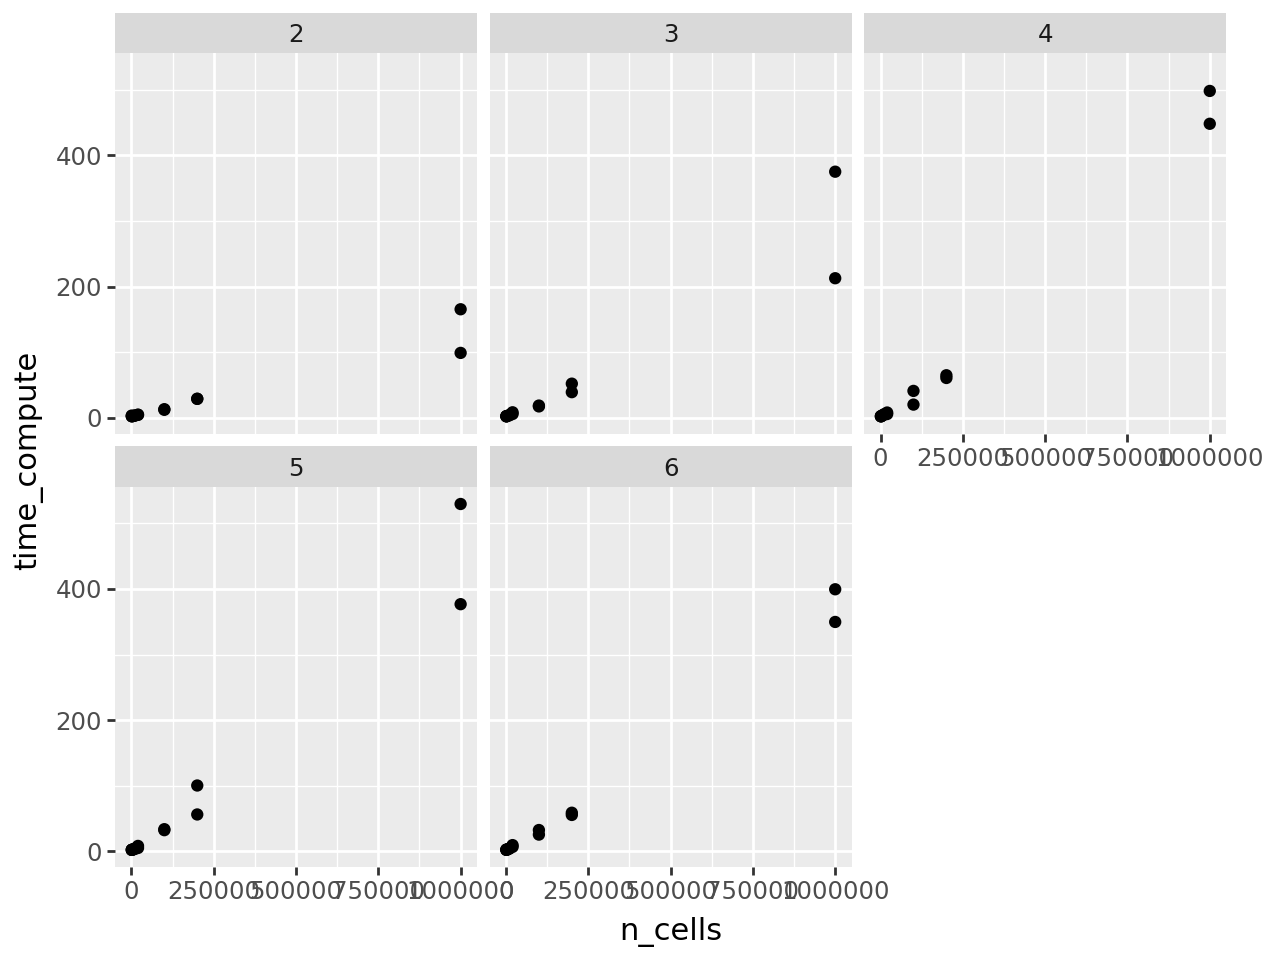

In [13]:
pn.ggplot(memory_bench) + pn.geom_point(pn.aes(x="n_cells", y="time_compute")) + pn.facet_wrap("n_archetypes")